# <center> [INDICIUM] - Processo Seletivo - Lighthouse Programa de Formação em Dados (Remoto) </center>
    
# <center> Treino e Teste do Modelo</center>

### Objetivo: Identificar quais máquinas apresentam potencial de falha tendo como base dados extraídos através de sensores durante o processo de manufatura. ###

In [1]:
#Import das libs necessárias no projeto
import pandas as pd
import seaborn as sn
import numpy as np

import matplotlib.pyplot as plt


#bliblotecas para a preparação do modelo
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

#import o classificador 
import lightgbm as lgb

from xgboost import XGBClassifier

from sklearn import svm

#import label encoder
from sklearn import preprocessing

from sklearn.multioutput import MultiOutputClassifier

from numpy import argmax 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


from pandasql import sqldf

In [2]:
#Ler os dados do csv e transformar em um dataframe para possibilitar a sua manipulação
df_treino = pd.read_csv("./desafio_manutencao_preditiva_treino.csv")
df_teste = pd.read_csv("./desafio_manutencao_preditiva_teste.csv")

In [3]:
print("Shape train: %s, test: %s" % (df_treino.shape, df_teste.shape))

Shape train: (6667, 9), test: (3333, 8)


In [4]:
df_treino.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure


## Parte 1 - Transformação e Preprocessamento dos dados

In [5]:
#Criando outro dataframe com base no original para poder manipular os dados 
#Importante: Só serão copiados as colunas necessárias para o processo de transformação e treino do modelo. 
df_treino_tf = df_treino[["air_temperature_k", "process_temperature_k", "rotational_speed_rpm", "torque_nm", "tool_wear_min", "failure_type"]].copy()

In [6]:
#o novo dataframe criado
df_treino_tf.head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,298.1,308.6,1551,42.8,0,No Failure
1,298.2,308.7,1408,46.3,3,No Failure
2,298.2,308.7,1408,40.0,9,No Failure
3,298.1,308.6,1425,41.9,11,No Failure
4,298.1,308.6,1558,42.4,14,No Failure


In [7]:
df_treino_tf['failure_type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [8]:
df_treino["failure_type"].value_counts()

No Failure                  6435
Heat Dissipation Failure      75
Power Failure                 63
Overstrain Failure            52
Tool Wear Failure             30
Random Failures               12
Name: failure_type, dtype: int64

Na análise exploratória dos dados foi detectado que a classe 'No Failure' tem um número expressivamente maior que as demais classes. Esse fator pode dar um problema no processo de classificação tendo em vista que o desbalanceamento entre as classes tende o resultado para classe mais expressiva, como no caso da base de dados é a classe 'No Failure'. Para testar essa hipótese será criado um modelo utilizando o classificador 

In [9]:
#transformar o y  
#make an instance of Label Encoder
label_encoder = preprocessing.LabelEncoder()
df_treino_tf["failure_type"] = label_encoder.fit_transform(df_treino_tf["failure_type"])

## Parte 2 - Testes de adequação

O objetivo dessa parte é testar qual o melhor modelo de dados a ser utilizado. Se deixa o modelo multiclass, com os rótulos originais do banco de dados, ou se agrupa todos os tipos de falhas em uma única coluna Failure.

### 1. Teste 1 - Sem balanceamento em as classes

Nesse teste as classes não serão balanceadas

In [10]:
#definindo o y
y = df_treino_tf["failure_type"]
y.sample(3)

6177    1
6111    3
4970    1
Name: failure_type, dtype: int64

In [11]:
#retirando o y do conjunto de treino e as colunas que não seram utilizadas durante o processo de treinamento
df_treino_tf.drop(["failure_type"], axis=1, inplace=True)

In [12]:
df_treino_tf

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,298.1,308.6,1551,42.8,0
1,298.2,308.7,1408,46.3,3
2,298.2,308.7,1408,40.0,9
3,298.1,308.6,1425,41.9,11
4,298.1,308.6,1558,42.4,14
...,...,...,...,...,...
6662,298.8,308.3,1634,27.9,12
6663,298.8,308.4,1604,29.5,14
6664,298.9,308.4,1632,31.8,17
6665,299.0,308.7,1408,48.5,25


In [13]:
#definindo o conjunto de treino
X_train, X_test, y_train, y_test = train_test_split(df_treino_tf, y, test_size=0.2, random_state=42)

#### a) Classifier Light Gradient Boosting Machine (LightGBM)

O primeiro classificador a ser testado será o LightGBM. Ele é **Gradient Boosting Framework** que utiliza da lógica de aprendizado por Árvore de Decisão. A vantagem desse classificador em relação aos demais é que a árvore cresce verticalmente, o algoritmo seleciona a "folha que tenha o máximo delta **loss to grow**.

Referência: B. Wang, Y. Wang, K. Qin and Q. Xia, "Detecting Transportation Modes Based on LightGBM Classifier from GPS Trajectory Data," 2018 26th International Conference on Geoinformatics, Kunming, China, 2018, pp. 1-7, doi: 10.1109/GEOINFORMATICS.2018.8557149.


In [14]:
#definindo os parâmetros
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_class': 6
} 

In [15]:
# laoding data
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [16]:
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 915
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 5
[LightGBM] [Info] Start training from score -4.438534
[LightGBM] [Info] Start training from score -0.036472
[LightGBM] [Info] Start training from score -4.868097
[LightGBM] [Info] Start training from score -4.630425
[LightGBM] [Info] Start training from score -6.384445
[LightGBM] [Info] Start training from score -5.323573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0'

In [17]:
y_pred = model.predict(X_test)

y_pred = argmax(y_pred, axis=1)
cr = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

/home/dani/anaconda3/envs/env_deep/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
print(cr)
print(cm) 

              precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       0.99      1.00      0.99      1293
           2       0.62      0.45      0.53        11
           3       0.60      0.55      0.57        11
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         4

    accuracy                           0.98      1334
   macro avg       0.54      0.46      0.49      1334
weighted avg       0.97      0.98      0.98      1334

[[   9    3    0    0    0    0]
 [   0 1287    2    3    0    1]
 [   0    5    5    1    0    0]
 [   0    4    1    6    0    0]
 [   0    3    0    0    0    0]
 [   0    4    0    0    0    0]]


Recall: De todos as falhas as que realmente são positivos, qual percentual é identificado corretamente pelo modelo.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

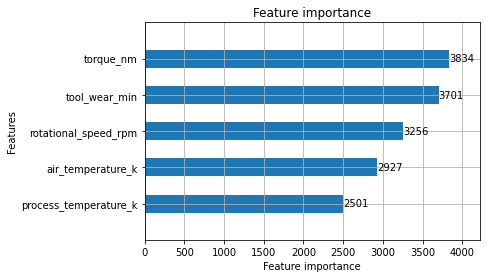

In [19]:
lgb.plot_importance(model, height=.5)

#### b) Classifier SVM